### CMPE 297 Sec 98
### Assignment 3
### Samuel Yang

## Part (a) 

### Dog breed Classifier

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']))#, 133)
    return dog_files, dog_targets
# load train, test, and validation datasets

#dir_name = 'dogImages_test'
dir_name = 'dogImages'

train_files, train_targets = load_dataset(dir_name + '/train')
valid_files, valid_targets = load_dataset(dir_name + '/valid')
test_files, test_targets = load_dataset(dir_name + '/test')
# load list of dog names
# the [20:-1] portion simply removes the filepath and folder number
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]
# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [3]:
# Detect Dogs

In [4]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    """Takes path to single image and returns it as a 4D tensor"""
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    """Takes list of image paths and returns array of 4D image arrays"""
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [5]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:11<00:00, 73.79it/s] 


In [6]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
model = Sequential()
# Define model architecture.
model.add(Conv2D(16, kernel_size=2, activation='relu', input_shape=(224,224,3))) # activation nonlinearity typically performed before pooling
model.add(MaxPooling2D()) # defaults to pool_size = (2,2), stride = None = pool_size
model.add(Conv2D(32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())

#numbber = catergories
model.add(Dense(133, activation='softmax'))
#model.add(Dense(20, activation='softmax'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)               

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
from keras.callbacks import ModelCheckpoint
import h5py

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', verbose=1, save_best_only=True)
history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=3, batch_size=20, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/3
 - 267s - loss: 4.8850 - accuracy: 0.0081 - val_loss: 4.8701 - val_accuracy: 0.0168

Epoch 00001: val_loss improved from inf to 4.87012, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/3
 - 256s - loss: 4.8532 - accuracy: 0.0121 - val_loss: 4.8255 - val_accuracy: 0.0156

Epoch 00002: val_loss improved from 4.87012 to 4.82547, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/3
 - 261s - loss: 4.7876 - accuracy: 0.0192 - val_loss: 4.7836 - val_accuracy: 0.0216

Epoch 00003: val_loss improved from 4.82547 to 4.78361, saving model to saved_models/weights.best.from_scratch.hdf5


In [10]:
def plot_loss(hist, name, plt):
    """Plots loss of of model on training and validation data, with legend"""
    loss = hist['loss']
    val_loss = hist['val_loss']
        
    plt.plot(loss, "--", linewidth=3, label="train: "+name)
    plt.plot(val_loss, linewidth=3, label="val: "+name)

In [11]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(8,8))
plot_loss(history.history,"From scratch model",plt)

plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

<Figure size 800x800 with 1 Axes>

In [12]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 1.6746%


## VGG

In [13]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

In [14]:
bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz')
train_VGG19 = bottleneck_features['train']
valid_VGG19 = bottleneck_features['valid']
test_VGG19 = bottleneck_features['test']

In [15]:
#There are 1179 training dog images.
#There are 144 validation dog images.
#There are 153 test dog images.
print(len(train_VGG19), len(valid_VGG19), len(test_VGG19))

6680 835 836


In [16]:
#parse
#train_VGG19 = train_VGG19[:1179]
#valid_VGG19 = valid_VGG19[:144]
#test_VGG19 = test_VGG19[:153]
print(len(train_VGG19), len(valid_VGG19), len(test_VGG19))

6680 835 836


In [17]:
VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))

#number of category
VGG19_model.add(Dense(133, activation='softmax'))
#VGG19_model.add(Dense(20, activation='softmax'))

VGG19_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [18]:
VGG19_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [19]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

vgg19_hist = VGG19_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 4s 577us/step - loss: 7.6366 - accuracy: 0.2398 - val_loss: 3.4172 - val_accuracy: 0.4455

Epoch 00001: val_loss improved from inf to 3.41725, saving model to saved_models/weights.best.VGG19.hdf5
Epoch 2/20
6680/6680 [==============================] - 2s 329us/step - loss: 1.9709 - accuracy: 0.6266 - val_loss: 2.3681 - val_accuracy: 0.5916

Epoch 00002: val_loss improved from 3.41725 to 2.36807, saving model to saved_models/weights.best.VGG19.hdf5
Epoch 3/20
6680/6680 [==============================] - 2s 287us/step - loss: 1.1167 - accuracy: 0.7572 - val_loss: 2.1647 - val_accuracy: 0.6275

Epoch 00003: val_loss improved from 2.36807 to 2.16471, saving model to saved_models/weights.best.VGG19.hdf5
Epoch 4/20
6680/6680 [==============================] - 2s 276us/step - loss: 0.7357 - accuracy: 0.8274 - val_loss: 1.9596 - val_accuracy: 0.6707

Epoch 00004: val_loss improved from 2.1647

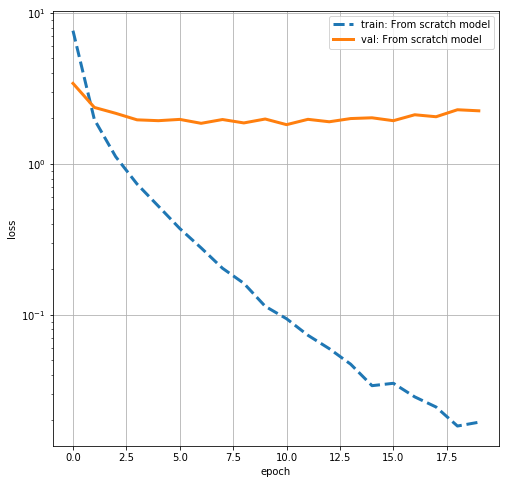

In [20]:
plt.figure(figsize=(8,8))
plot_loss(vgg19_hist.history,"From scratch model",plt)

plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [21]:
VGG19_model.load_weights('saved_models/weights.best.VGG19.hdf5')

VGG19_predictions = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG19_predictions)==np.argmax(test_targets, axis=1))/len(VGG19_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 73.3254%


## Transfer Learning

In [22]:
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

In [23]:
print(len(train_Resnet50), len(valid_Resnet50), len(test_Resnet50))

6680 835 836


In [24]:
#parse
#train_Resnet50 = train_VGG19[:1179]
#valid_Resnet50 = valid_VGG19[:144]
#test_Resnet50 = test_VGG19[:153]
#print(len(train_Resnet50), len(valid_Resnet50), len(test_Resnet50))

In [25]:
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))
#Resnet50_model.add(Dense(20, activation='softmax'))

Resnet50_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [26]:
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [27]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

resnet50_hist = Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=56, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s 146us/step - loss: 4.0901 - accuracy: 0.1638 - val_loss: 3.0905 - val_accuracy: 0.3593

Epoch 00001: val_loss improved from inf to 3.09053, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 2/20
6680/6680 [==============================] - 1s 110us/step - loss: 2.4294 - accuracy: 0.5250 - val_loss: 2.0723 - val_accuracy: 0.5964

Epoch 00002: val_loss improved from 3.09053 to 2.07233, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 3/20
6680/6680 [==============================] - 1s 98us/step - loss: 1.6668 - accuracy: 0.6847 - val_loss: 1.5829 - val_accuracy: 0.6790

Epoch 00003: val_loss improved from 2.07233 to 1.58287, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 4/20
6680/6680 [==============================] - 1s 106us/step - loss: 1.2774 - accuracy: 0.7548 - val_loss: 1.3207 - val_accuracy: 0.7210

Epoch 00004: val_loss improved fro

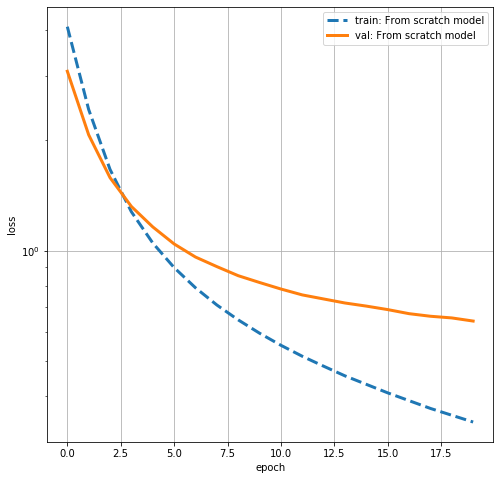

In [28]:
plt.figure(figsize=(8,8))
plot_loss(resnet50_hist.history,"From scratch model",plt)

plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [29]:
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 82.5359%


## Part (b) 

### Input Sample Dog Image

In [69]:
def Resnet50_predict_breed(img_path):
    #extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    #print(bottleneck_feature.shape) #returns (1, 2048)
    bottleneck_feature = np.expand_dims(bottleneck_feature, axis=0)
    bottleneck_feature = np.expand_dims(bottleneck_feature, axis=0)
    
    predicted_vector = Resnet50_model.predict(bottleneck_feature) #shape error occurs here
    
    return dog_names[np.argmax(predicted_vector)]

In [70]:
import cv2

def verify_breed(img_path):
    print("This dog looks like a {}".format(Resnet50_predict_breed(img_path)))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [71]:
def extract_Resnet50(tensor):
    from keras.applications.resnet50 import ResNet50, preprocess_input
    return ResNet50(weights='imagenet', include_top=False, pooling="avg").predict(preprocess_input(tensor))

def extract_VGG16(tensor):
    from keras.applications.vgg16 import VGG16, preprocess_input
    return VGG16(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def extract_VGG19(tensor):
    from keras.applications.vgg19 import VGG19, preprocess_input
    return VGG19(weights='imagenet', include_top=False).predict(preprocess_input(tensor))


### Classification

This dog looks like a Curly-coated_retriever


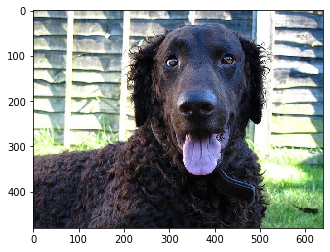

In [73]:
verify_breed('images/test_Cur.jpg')

This dog looks like a Australian_cattle_dog


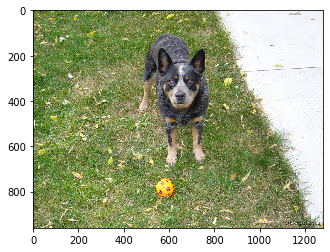

In [74]:
verify_breed('images/test_Aus.jpg')

This dog looks like a Akita


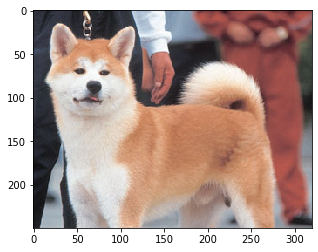

In [75]:
verify_breed('images/test_Akita.jpg')

This dog looks like a Boston_terrier


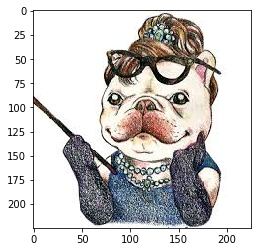

In [79]:
verify_breed('images/random.jpg')

This dog looks like a Finnish_spitz


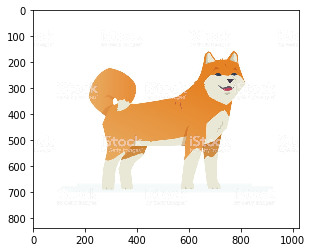

In [77]:
verify_breed('images/random2.jpg')

#### First three classicifications were actually pretty accurate. The last two were similar to the results.